In [1]:
! git clone https://github.com/CMinge1777/FileVtaFarMDF.git

Cloning into 'FileVtaFarMDF'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 143.23 KiB | 805.00 KiB/s, done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [33]:
DF=pd.read_excel('/content/FileVtaFarMDF/VtaDFarma.xlsx')

In [34]:
DF

,Date,Venta
0,2017-01-05,191853236
1,2017-01-06,237758605
2,2017-01-10,108056652
3,2017-01-11,195089810
4,2017-01-12,344686288
...,...,...
2012,2025-04-25,166256023
2013,2025-04-26,78161343
2014,2025-04-28,302504850
2015,2025-04-29,269759469


## Modelo ARIMA

<h2>Se hace una división los datos en porciones </h2>

In [5]:
train_size = int(len(DF) * 0.8)
train, test = DF[0:train_size], DF[train_size:len(DF)]

In [6]:
def rmse(predict, actual):
  """
  Calculates the Root Mean Squared Error (RMSE) between true and predicted values.

  Args:
    y_true: Array or list of true values.
    y_pred: Array or list of predicted values.

  Returns:
    The RMSE value.
  """
  squared_differences =[(predict - actual)**2 for predict, actual in zip(predict, actual)]

  mean_squared_error = sum(squared_differences)/len(squared_differences)
  rmse = mean_squared_error**0.5

  return rmse

# Evaluación de modelos de series temporales
<h3>MAPE</h2>
<h2>RMSE</h2>

In [35]:
DF['Date'] = pd.to_datetime(DF['Date'])
DF.set_index('Date', inplace=True)

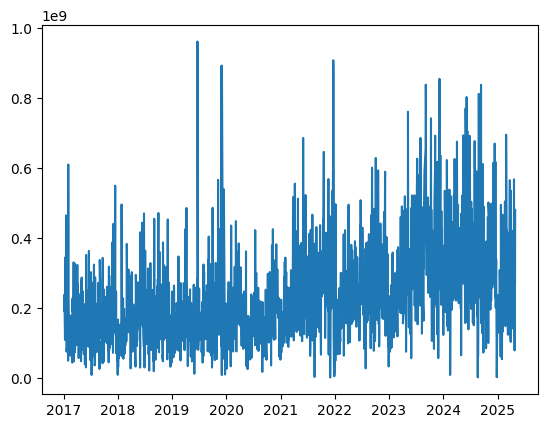

In [36]:
plt.plot(DF['Venta'])

In [37]:
DF.head()

,Venta
Date,
2017-01-05,191853236
2017-01-06,237758605
2017-01-10,108056652
2017-01-11,195089810
2017-01-12,344686288


In [10]:
DF.tail()

,Venta
Date,
2025-04-25,166256023
2025-04-26,78161343
2025-04-28,302504850
2025-04-29,269759469
2025-04-30,480312239


In [38]:
#Validación del index
DF.index[0]

Timestamp('2017-01-05 00:00:00')

<ipython-input-39-4c274575a118>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  DF_monthly = DF.resample('M').sum()


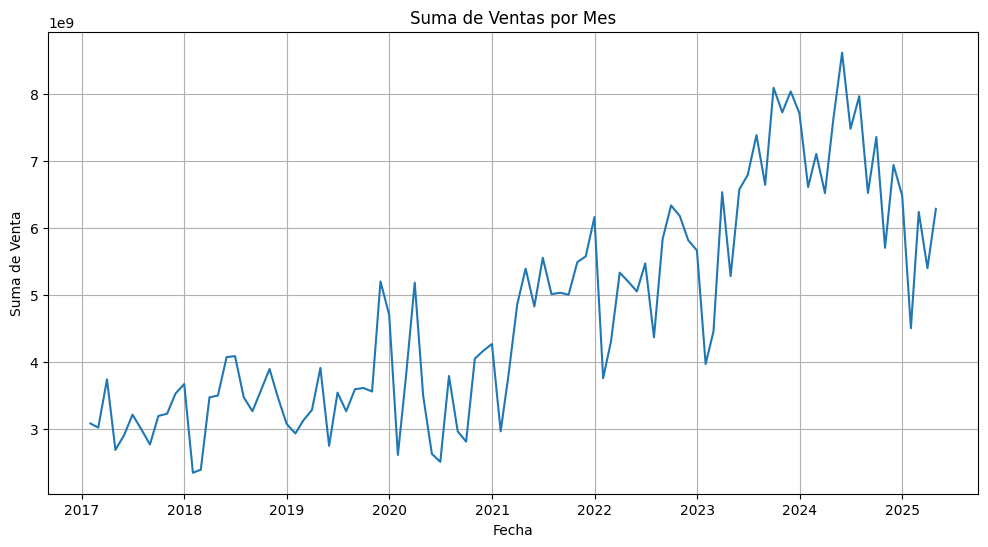

In [39]:
# Suma Venta/Mes
DF_monthly = DF.resample('M').sum()
plt.figure(figsize=(12, 6))
plt.plot(DF_monthly['Venta'])
plt.title('Suma de Ventas por Mes')
plt.xlabel('Fecha')
plt.ylabel('Suma de Venta')
plt.grid(True)
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
train = DF_monthly[DF_monthly.index < '2023-04-01']
test = DF_monthly[DF_monthly.index >= '2023-04-01']

In [14]:
mod = ARIMA(DF_monthly['Venta'], order=(12, 2, 3))
res = mod.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


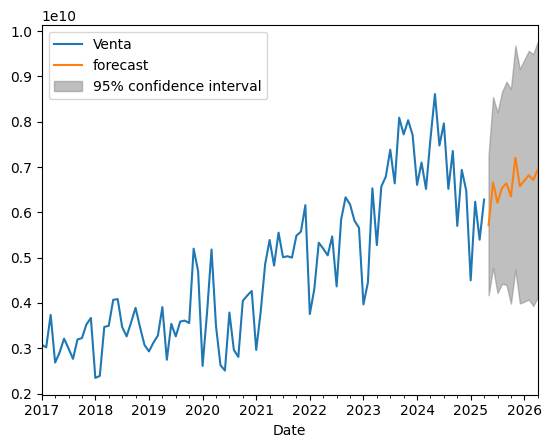

In [15]:
fig, ax = plt.subplots()
ax = DF_monthly.plot(ax=ax)
last_month_in_data = DF_monthly.index[-1]
start_forecast = last_month_in_data + pd.DateOffset(months=1)
end_forecast = start_forecast + pd.DateOffset(months=11)

plot_predict(res, start=start_forecast, end=end_forecast, ax=ax)
plt.show()

In [16]:
# Promt de clase para calcular el mape (valores verdaderos y la predicción)

def mape(actual, pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE) between true and predicted values.

    Args:
        actual: Array or list of true values.
        pred: Array or list of predicted values.

    Returns:
        The MAPE value.
    """
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#Toma de datos según el index
start_test_date = test.index[0]
end_test_date = test.index[-1]


pred = res.predict(start=start_test_date, end=end_test_date)

mape_value = mape(test['Venta'].values, pred.values)

print(f"MAPE: {mape_value:.2f}%")

MAPE: 10.16%


In [17]:
from sklearn.metrics import r2_score

r_squared = r2_score(test['Venta'].values, pred.values)

print(f"R-squared: {r_squared:.4f}")


R-squared: 0.2720


<h2>Función de autocorrelación</h2>

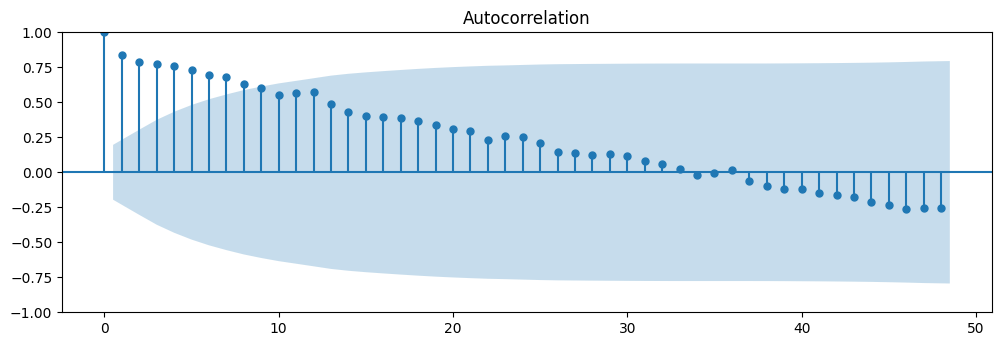

In [18]:
#Grafico acf correlación
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(DF_monthly['Venta'], lags=48, ax=ax1)

<h2>Función de autocorrelación parcial</h2>

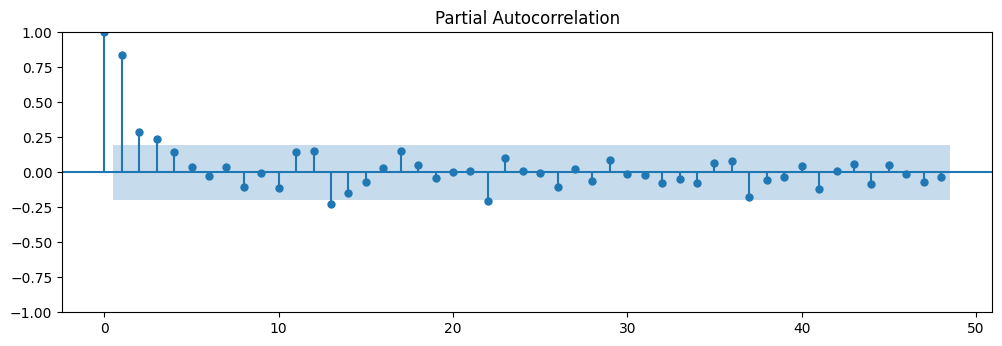

In [19]:
# gráfico del pacf correlacion

fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(DF_monthly['Venta'], lags=48, ax=ax2)
plt.show()

## Machine Learning

In [20]:
DF_monthly['rezago']= DF_monthly['Venta'].shift(1)

In [21]:
DF_monthly

,Venta,rezago
Date,,
2017-01-31,3079645491,NaN
2017-02-28,3018961104,3.079645e+09
2017-03-31,3737462068,3.018961e+09
2017-04-30,2685242134,3.737462e+09
2017-05-31,2906921920,2.685242e+09
...,...,...
2024-12-31,6478455593,6.935565e+09
2025-01-31,4499882539,6.478456e+09
2025-02-28,6233745884,4.499883e+09


In [22]:
umbral = int(0.8*len(DF_monthly))

In [23]:
train = DF_monthly.iloc[:umbral]
test = DF_monthly.iloc[umbral:]

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
xtrain = train['rezago'][1:].values.reshape(-1, 1)
ytrain = train['Venta'][1:].values.reshape(-1, 1)

In [26]:
model = LinearRegression()
xtest = test['rezago'][1:].values.reshape(-1, 1)
ytest = test['Venta'][1:].values.reshape(-1, 1)

In [27]:
model.fit(xtrain, ytrain)

LinearRegression()

In [28]:
ypred = model.predict(xtest)

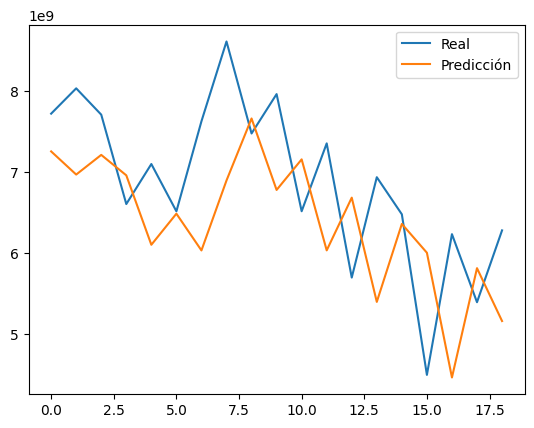

In [29]:
plt.plot(ytest, label='Real')
plt.plot(ypred, label='Predicción')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import r2_score

In [31]:
r2_score(ytest, ypred)

-0.1782375647517478

<h3>Rezagos</h3>

In [ ]:
##Base de datos
DF=pd.read_excel('/content/FileVtaFarMDF/VtaDFarma.xlsx')

In [ ]:
#Datos pasados a Mes
DF_monthly = DF.resample('M').sum()

In [40]:
DF_monthly

,Venta
Date,
2017-01-31,3079645491
2017-02-28,3018961104
2017-03-31,3737462068
2017-04-30,2685242134
2017-05-31,2906921920
...,...
2024-12-31,6478455593
2025-01-31,4499882539
2025-02-28,6233745884


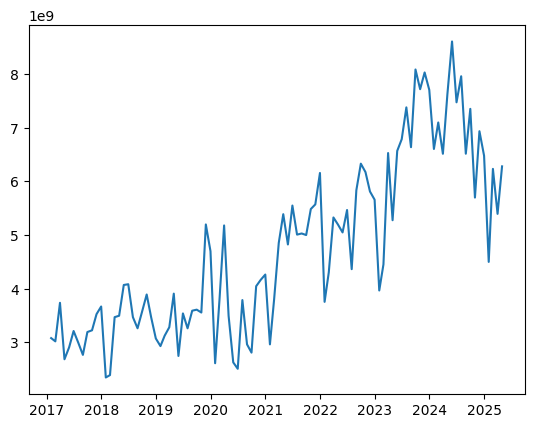

In [41]:
plt.plot(DF_monthly['Venta'])

In [48]:
bdarreglo = DF_monthly.to_numpy().flatten()

In [49]:
def cmatriz (serieT, win=3, horiz= 3):
  matrizin = []
  matrizout = []
  for i in range(len(bdarreglo)-win-horiz):
    matrizin.append(serieT[i:i+win])
    matrizout.append(serieT[i+win+horiz])
  return np.array(matrizin),np.array(matrizout)

In [50]:
X,y = cmatriz(bdarreglo, 10, 5)

In [51]:
def train_test_split(matrizin,matrizout, test_size=0.2):
  intrain = matrizin[:int(len(matrizin)*(1-test_size))]
  intest = matrizin[:int(len(matrizin)*(1-test_size)):]
  outtrain = matrizout[:int(len(matrizout)*(1-test_size))]
  outtest = matrizout[:int(len(matrizout)*(1-test_size)):]
  return intrain,intest,outtrain,outtest

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
model = LinearRegression()
model.fit(X_train, y_train)
yPred = model.predict(X_test)

In [55]:
yPred

array([3.47547051e+09, 3.34353357e+09, 3.84092580e+09, 3.10863966e+09,
       3.14082091e+09, 3.41227272e+09, 3.63418693e+09, 4.10705533e+09,
       3.99139627e+09, 3.37650351e+09, 3.17405177e+09, 3.74126339e+09,
       3.95000217e+09, 3.96798559e+09, 4.25526138e+09, 3.79671236e+09,
       3.74730850e+09, 4.02491376e+09, 4.27339223e+09, 3.69331396e+09,
       3.80145792e+09, 3.45594809e+09, 3.71423640e+09, 3.87154338e+09,
       3.80794625e+09, 4.32323110e+09, 3.83247555e+09, 4.03886590e+09,
       3.92373757e+09, 4.19915099e+09, 4.18052520e+09, 4.82703595e+09,
       4.32053330e+09, 3.70400975e+09, 4.08312750e+09, 5.03829999e+09,
       4.21626232e+09, 3.35865383e+09, 4.21944741e+09, 3.67570463e+09,
       3.79233663e+09, 3.56621110e+09, 4.72408781e+09, 5.01005704e+09,
       4.77855282e+09, 4.43577506e+09, 4.66294888e+09, 5.51259858e+09,
       5.56829870e+09, 5.80295032e+09, 6.19540464e+09, 5.69360488e+09,
       5.59695495e+09, 5.82615498e+09, 5.95334905e+09, 6.56272482e+09,
      

In [59]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

In [57]:
mean_absolute_percentage_error(y_test, yPred)

0.16652524836313276

In [60]:
root_mean_squared_error(y_test, yPred)

857179751.9562238

In [61]:
r2_score(y_test, yPred)

0.6135381826551736

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
model_rfr = RandomForestRegressor(n_estimators=100)
model_rfr.fit(X_train, y_train)
yPred_rfr = model_rfr.predict(X_test)

In [66]:
mean_absolute_percentage_error(y_test, yPred_rfr)

0.06407898439876031

In [ ]:
!pip install xgboost
import xgboost as xgb

In [71]:
#Xgboost
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgbr.fit(X_train, y_train)
yPred_xgb = xgbr.predict(X_test)
print("XGBoost Metrics:")

print(f"MAPE: {mean_absolute_percentage_error(y_test, yPred_xgb):.2f}%")
print(f"RMSE: {root_mean_squared_error(y_test, yPred_xgb):.2f}")
print(f"R-squared: {r2_score(y_test, yPred_xgb):.4f}")

XGBoost Metrics:
MAPE: 0.00%
RMSE: 590.66
R-squared: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step

RNN (LSTM) Metrics:
MAPE: 0.34%
RMSE: 2490735689.32
R-squared: -5.4577


In [72]:
!pip install tensorflow scikit-learn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#RNN (LSTM)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)) # Reshape y for the scaler

# Split the scaled data
umbral = int(0.8 * len(X_scaled))
X_train_scaled, X_test_scaled = X_scaled[:umbral], X_scaled[umbral:]
y_train_scaled, y_test_scaled = y_scaled[:umbral], y_scaled[umbral:] # Corrected typo here
# Corrected the split for y_scaled test set
y_train_scaled, y_test_scaled = y_scaled[:umbral], y_scaled[umbral:]


# Escalada de datos para LSTM [samples, time steps, features]
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Construcción modelo RNN
model_rnn = Sequential()
model_rnn.add(LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')

# Train el modelo
history = model_rnn.fit(X_train_rnn, y_train_scaled,
                        epochs=200,
                        batch_size=32,
                        verbose=0) #epochs para mejor train

# Predicción escaled datos test
yPred_rnn_scaled = model_rnn.predict(X_test_rnn)

# Ajuste, inversa y transformación de la predicción
yPred_rnn = scaler_y.inverse_transform(yPred_rnn_scaled)

# transforma el actual valores de test a el original para calculos de metricas
y_test_original = scaler_y.inverse_transform(y_test_scaled)

print("\nRNN (LSTM) Metrics:")
# Datos originales y escalados "metric calculation"
print(f"MAPE: {mean_absolute_percentage_error(y_test_original, yPred_rnn):.2f}%")
print(f"RMSE: {root_mean_squared_error(y_test_original, yPred_rnn):.2f}")
print(f"R-squared: {r2_score(y_test_original, yPred_rnn):.4f}")

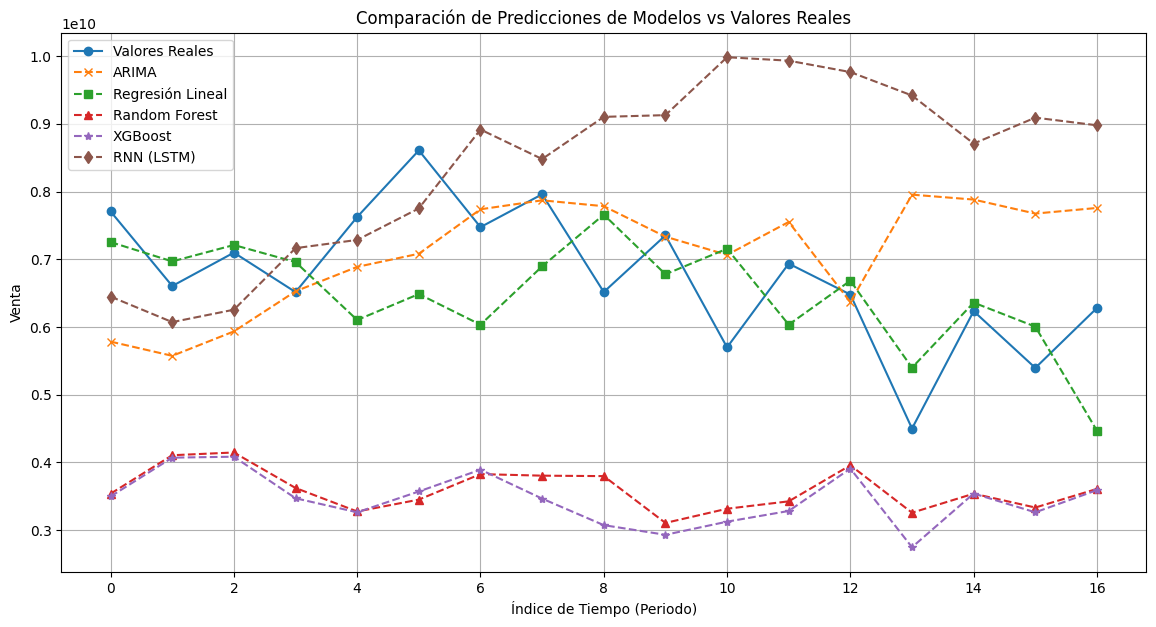


Tabla Comparativa de Métricas de Modelos:
          Modelo   R2 Score         RMSE  MAPE (%)
           ARIMA  -1.140577 1.434011e+09 18.378713
Regresión Lineal  -0.204415 1.075661e+09  0.133104
   Random Forest -10.439190 3.315010e+09  0.457896
         XGBoost -11.249774 3.430451e+09  0.480817
      RNN (LSTM)  -5.457745 2.490736e+09  0.341157


In [73]:
actual_values = y_test_original.flatten() # Use the actual values from the LSTM test set as the common ground
arima_pred = pred.values # ARIMA
linear_reg_pred = ypred.flatten() # Linear Regression predictions
rfr_pred = yPred_rfr.flatten() # Random Forest predictions
xgb_pred = yPred_xgb.flatten() # XGBoost predictions
rnn_pred = yPred_rnn.flatten() # RNN (LSTM) predictions


min_len = min(len(actual_values), len(arima_pred), len(linear_reg_pred), len(rfr_pred), len(xgb_pred), len(rnn_pred))

actual_values = actual_values[:min_len]
arima_pred = arima_pred[:min_len]
linear_reg_pred = linear_reg_pred[:min_len]
rfr_pred = rfr_pred[:min_len]
xgb_pred = xgb_pred[:min_len]
rnn_pred = rnn_pred[:min_len]


# PLot de compración
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Valores Reales', marker='o', linestyle='-')
plt.plot(arima_pred, label='ARIMA', marker='x', linestyle='--')
plt.plot(linear_reg_pred, label='Regresión Lineal', marker='s', linestyle='--')
plt.plot(rfr_pred, label='Random Forest', marker='^', linestyle='--')
plt.plot(xgb_pred, label='XGBoost', marker='*', linestyle='--')
plt.plot(rnn_pred, label='RNN (LSTM)', marker='d', linestyle='--')


plt.title('Comparación de Predicciones de Modelos vs Valores Reales')
plt.xlabel('Índice de Tiempo (Periodo)')
plt.ylabel('Venta')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics for each model
arima_mape = mape(actual_values, arima_pred)
arima_rmse = root_mean_squared_error(actual_values, arima_pred)
arima_r2 = r2_score(actual_values, arima_pred)

linear_reg_mape = mean_absolute_percentage_error(actual_values, linear_reg_pred)
linear_reg_rmse = root_mean_squared_error(actual_values, linear_reg_pred)
linear_reg_r2 = r2_score(actual_values, linear_reg_pred)

rfr_mape = mean_absolute_percentage_error(actual_values, rfr_pred)
rfr_rmse = root_mean_squared_error(actual_values, rfr_pred)
rfr_r2 = r2_score(actual_values, rfr_pred)

xgb_mape = mean_absolute_percentage_error(actual_values, xgb_pred)
xgb_rmse = root_mean_squared_error(actual_values, xgb_pred)
xgb_r2 = r2_score(actual_values, xgb_pred)

rnn_mape = mean_absolute_percentage_error(actual_values, rnn_pred)
rnn_rmse = root_mean_squared_error(actual_values, rnn_pred)
rnn_r2 = r2_score(actual_values, rnn_pred)

# Create a DataFrame for the metrics table
metrics_data = {
    'Modelo': ['ARIMA', 'Regresión Lineal', 'Random Forest', 'XGBoost', 'RNN (LSTM)'],
    'R2 Score': [arima_r2, linear_reg_r2, rfr_r2, xgb_r2, rnn_r2],
    'RMSE': [arima_rmse, linear_reg_rmse, rfr_rmse, xgb_rmse, rnn_rmse],
    'MAPE (%)': [arima_mape, linear_reg_mape, rfr_mape, xgb_mape, rnn_mape]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the metrics table
print("\nTabla Comparativa de Métricas de Modelos:")
print(metrics_df.to_string(index=False))
